In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/polymer')
mask_dir = os.path.join(dataset_dir,'mask/polymer')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/polymer C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/polymer
15761
15761


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\check_version.py:51: UserWarning: Error fetching version info <urlopen error _ssl.c:1130: The handshake operation timed out>
  data = fetch_version_info()


[2025-02-16 11:04:16,519: INFO: 3804955329: date_time: 20250216-110416]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "linknet",
    "backbone" : "vgg19", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-02-16 11:04:16,686: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-02-16 11:04:16,686: INFO: 342151172: model_config: {'model_name': 'linknet', 'backbone': 'vgg19', 'weights': 'imagenet', 'in_channels': 3}]
[2025-02-16 11:04:16,687: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-02-16 11:04:16,689: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

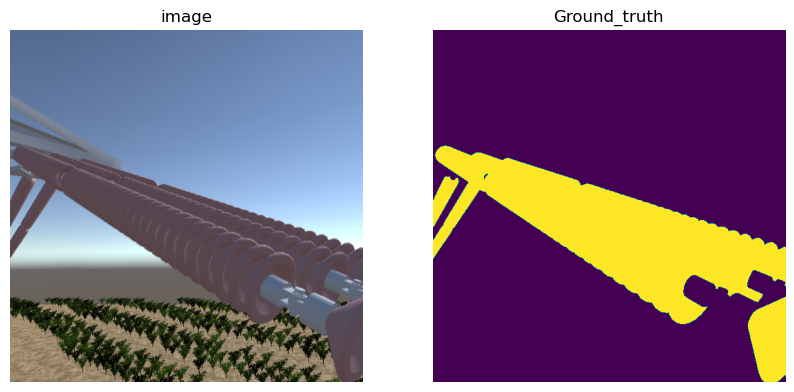

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-02-16 11:04:17,305: INFO: 3993860970: data injection started]
[2025-02-16 11:04:17,311: INFO: 3993860970: train data spliting ]
[2025-02-16 11:04:17,313: INFO: 3993860970: val test spliting ]
[2025-02-16 11:04:17,315: INFO: 3993860970: csv saving started]
[2025-02-16 11:04:17,371: INFO: 3993860970: train csv done ]
[2025-02-16 11:04:17,377: INFO: 3993860970: val csv done ]
[2025-02-16 11:04:17,384: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [17]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []
dice_coefficient_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []
dice_coefficient = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_iou_score_for_training.append(mean_miou_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_coefficient_for_training.append((2*jeq_indx_for_training*1/(1+jeq_indx_for_training)))
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training),
                                    "train_dice_coefficient": sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    logger.info(f"train_dice_coefficient: {sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)}")

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                                     "eval_dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"eval_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 2102/2102 [10:25<00:00,  3.36it/s, epoch=0, train_loss=0.0243, train_Miou_score=0.486, train_dice_score=0.721, train_acc=0.982, train_binary_jaccard_index=0.876, train_dice_coefficient=0.929]

[2025-02-16 11:15:56,745: INFO: 2273413975: Epoch: 0 | Training_Loss: 0.024328941282604447]
[2025-02-16 11:15:56,746: INFO: 2273413975: train_loss 0.053089685392132824]
[2025-02-16 11:15:56,746: INFO: 2273413975: train_Miou_score 0.4860709132848185]
[2025-02-16 11:15:56,747: INFO: 2273413975: train_dice_score 0.7213536924111004]
[2025-02-16 11:15:56,747: INFO: 2273413975: train_acc 0.9815204437577532]
[2025-02-16 11:15:56,748: INFO: 2273413975: train_binary_jaccard_index: 0.8764343767840731]
[2025-02-16 11:15:56,749: INFO: 2273413975: train_dice_coefficient: 0.9293440012331042]



100%|██████████| 788/788 [00:49<00:00, 15.95it/s, epoch=0, eval_loss=0.0119, eval_Miou_score=0.505, eval_dice_score=0.789, eval_acc=0.988, eval_binary_jaccard_index=0.909, eval_dice_coefficient=0.948] 

[2025-02-16 11:16:46,154: INFO: 2273413975: Epoch: 0 | Loss: 0.011931946737512114]
[2025-02-16 11:16:46,156: INFO: 2273413975: eval_loss 0.011452656232172466]
[2025-02-16 11:16:46,156: INFO: 2273413975: eval_Miou_score 0.5053541512597296]
[2025-02-16 11:16:46,156: INFO: 2273413975: eval_dice_score 0.7889221941740229]
[2025-02-16 11:16:46,156: INFO: 2273413975: eval_acc 0.9883318044207423]
[2025-02-16 11:16:46,158: INFO: 2273413975: eval_binary_jaccard_index: 0.9085496888888366]
[2025-02-16 11:16:46,159: INFO: 2273413975: eval_dice_coefficient: 0.9479064158545447]



100%|██████████| 2102/2102 [10:16<00:00,  3.41it/s, epoch=1, train_loss=0.00899, train_Miou_score=0.501, train_dice_score=0.759, train_acc=0.986, train_binary_jaccard_index=0.906, train_dice_coefficient=0.948]

[2025-02-16 11:27:02,389: INFO: 2273413975: Epoch: 1 | Training_Loss: 0.008990862985433112]
[2025-02-16 11:27:02,390: INFO: 2273413975: train_loss 0.03161110245072946]
[2025-02-16 11:27:02,391: INFO: 2273413975: train_Miou_score 0.5010257162735022]
[2025-02-16 11:27:02,392: INFO: 2273413975: train_dice_score 0.7594403850373685]
[2025-02-16 11:27:02,393: INFO: 2273413975: train_acc 0.9863211290536893]
[2025-02-16 11:27:02,394: INFO: 2273413975: train_binary_jaccard_index: 0.9062005332117274]
[2025-02-16 11:27:02,394: INFO: 2273413975: train_dice_coefficient: 0.9475940956395481]



100%|██████████| 788/788 [00:48<00:00, 16.23it/s, epoch=1, eval_loss=0.0112, eval_Miou_score=0.507, eval_dice_score=0.805, eval_acc=0.989, eval_binary_jaccard_index=0.915, eval_dice_coefficient=0.952] 

[2025-02-16 11:27:50,966: INFO: 2273413975: Epoch: 1 | Loss: 0.011205487142359544]
[2025-02-16 11:27:50,967: INFO: 2273413975: eval_loss 0.011056335475413666]
[2025-02-16 11:27:50,967: INFO: 2273413975: eval_Miou_score 0.5073098023339331]
[2025-02-16 11:27:50,968: INFO: 2273413975: eval_dice_score 0.804656780646348]
[2025-02-16 11:27:50,968: INFO: 2273413975: eval_acc 0.9886188724924465]
[2025-02-16 11:27:50,969: INFO: 2273413975: eval_binary_jaccard_index: 0.9146506102273458]
[2025-02-16 11:27:50,969: INFO: 2273413975: eval_dice_coefficient: 0.9518112443461444]



100%|██████████| 2102/2102 [09:52<00:00,  3.55it/s, epoch=2, train_loss=0.00855, train_Miou_score=0.508, train_dice_score=0.775, train_acc=0.988, train_binary_jaccard_index=0.917, train_dice_coefficient=0.954]

[2025-02-16 11:37:43,759: INFO: 2273413975: Epoch: 2 | Training_Loss: 0.008547024087152744]
[2025-02-16 11:37:43,760: INFO: 2273413975: train_loss 0.024003952970353293]
[2025-02-16 11:37:43,761: INFO: 2273413975: train_Miou_score 0.5079382111132618]
[2025-02-16 11:37:43,762: INFO: 2273413975: train_dice_score 0.7752591443407301]
[2025-02-16 11:37:43,762: INFO: 2273413975: train_acc 0.9880487904392119]
[2025-02-16 11:37:43,763: INFO: 2273413975: train_binary_jaccard_index: 0.9171522565899654]
[2025-02-16 11:37:43,764: INFO: 2273413975: train_dice_coefficient: 0.9541899604337539]



100%|██████████| 788/788 [00:48<00:00, 16.26it/s, epoch=2, eval_loss=0.0042, eval_Miou_score=0.517, eval_dice_score=0.821, eval_acc=0.991, eval_binary_jaccard_index=0.932, eval_dice_coefficient=0.962] 

[2025-02-16 11:38:32,225: INFO: 2273413975: Epoch: 2 | Loss: 0.004200012626381695]
[2025-02-16 11:38:32,226: INFO: 2273413975: eval_loss 0.008723850505464944]
[2025-02-16 11:38:32,227: INFO: 2273413975: eval_Miou_score 0.5169804532627705]
[2025-02-16 11:38:32,227: INFO: 2273413975: eval_dice_score 0.8212357452218051]
[2025-02-16 11:38:32,228: INFO: 2273413975: eval_acc 0.9910222108392345]
[2025-02-16 11:38:32,228: INFO: 2273413975: eval_binary_jaccard_index: 0.9317652179139418]
[2025-02-16 11:38:32,229: INFO: 2273413975: eval_dice_coefficient: 0.9619216174324727]



100%|██████████| 2102/2102 [09:53<00:00,  3.54it/s, epoch=3, train_loss=0.0064, train_Miou_score=0.512, train_dice_score=0.788, train_acc=0.989, train_binary_jaccard_index=0.926, train_dice_coefficient=0.959] 

[2025-02-16 11:48:25,825: INFO: 2273413975: Epoch: 3 | Training_Loss: 0.00640280645422205]
[2025-02-16 11:48:25,826: INFO: 2273413975: train_loss 0.019892359172770303]
[2025-02-16 11:48:25,827: INFO: 2273413975: train_Miou_score 0.5119083762278764]
[2025-02-16 11:48:25,827: INFO: 2273413975: train_dice_score 0.7881056820162059]
[2025-02-16 11:48:25,828: INFO: 2273413975: train_acc 0.9894423400088224]
[2025-02-16 11:48:25,828: INFO: 2273413975: train_binary_jaccard_index: 0.9261753684473353]
[2025-02-16 11:48:25,829: INFO: 2273413975: train_dice_coefficient: 0.9594722395933998]



100%|██████████| 788/788 [00:47<00:00, 16.47it/s, epoch=3, eval_loss=0.00649, eval_Miou_score=0.517, eval_dice_score=0.825, eval_acc=0.992, eval_binary_jaccard_index=0.937, eval_dice_coefficient=0.965]

[2025-02-16 11:49:13,684: INFO: 2273413975: Epoch: 3 | Loss: 0.006486701935075867]
[2025-02-16 11:49:13,684: INFO: 2273413975: eval_loss 0.008064384068343474]
[2025-02-16 11:49:13,685: INFO: 2273413975: eval_Miou_score 0.5171331897180593]
[2025-02-16 11:49:13,686: INFO: 2273413975: eval_dice_score 0.8249261008202085]
[2025-02-16 11:49:13,686: INFO: 2273413975: eval_acc 0.9916525933948265]
[2025-02-16 11:49:13,686: INFO: 2273413975: eval_binary_jaccard_index: 0.9368995115075847]
[2025-02-16 11:49:13,687: INFO: 2273413975: eval_dice_coefficient: 0.9649055803631983]



100%|██████████| 2102/2102 [09:52<00:00,  3.55it/s, epoch=4, train_loss=0.00639, train_Miou_score=0.515, train_dice_score=0.796, train_acc=0.99, train_binary_jaccard_index=0.932, train_dice_coefficient=0.963]

[2025-02-16 11:59:06,508: INFO: 2273413975: Epoch: 4 | Training_Loss: 0.00638856550946222]
[2025-02-16 11:59:06,509: INFO: 2273413975: train_loss 0.017082404143110772]
[2025-02-16 11:59:06,509: INFO: 2273413975: train_Miou_score 0.5147269311757114]
[2025-02-16 11:59:06,510: INFO: 2273413975: train_dice_score 0.7960245277764512]
[2025-02-16 11:59:06,510: INFO: 2273413975: train_acc 0.9902800679830683]
[2025-02-16 11:59:06,511: INFO: 2273413975: train_binary_jaccard_index: 0.9315551246458809]
[2025-02-16 11:59:06,512: INFO: 2273413975: train_dice_coefficient: 0.9626181209311827]



100%|██████████| 788/788 [00:48<00:00, 16.33it/s, epoch=4, eval_loss=0.00574, eval_Miou_score=0.519, eval_dice_score=0.828, eval_acc=0.992, eval_binary_jaccard_index=0.94, eval_dice_coefficient=0.967] 

[2025-02-16 11:59:54,758: INFO: 2273413975: Epoch: 4 | Loss: 0.0057398477181565336]
[2025-02-16 11:59:54,758: INFO: 2273413975: eval_loss 0.0075705041926460185]
[2025-02-16 11:59:54,760: INFO: 2273413975: eval_Miou_score 0.5189527547870985]
[2025-02-16 11:59:54,760: INFO: 2273413975: eval_dice_score 0.8276995670693326]
[2025-02-16 11:59:54,761: INFO: 2273413975: eval_acc 0.9921771707873659]
[2025-02-16 11:59:54,761: INFO: 2273413975: eval_binary_jaccard_index: 0.9404262323178313]
[2025-02-16 11:59:54,762: INFO: 2273413975: eval_dice_coefficient: 0.9669376800886746]



100%|██████████| 2102/2102 [09:53<00:00,  3.54it/s, epoch=5, train_loss=0.00528, train_Miou_score=0.517, train_dice_score=0.803, train_acc=0.991, train_binary_jaccard_index=0.937, train_dice_coefficient=0.965]

[2025-02-16 12:09:48,617: INFO: 2273413975: Epoch: 5 | Training_Loss: 0.005282745800281456]
[2025-02-16 12:09:48,618: INFO: 2273413975: train_loss 0.015152422639246373]
[2025-02-16 12:09:48,619: INFO: 2273413975: train_Miou_score 0.5172057286899713]
[2025-02-16 12:09:48,620: INFO: 2273413975: train_dice_score 0.803421717659915]
[2025-02-16 12:09:48,621: INFO: 2273413975: train_acc 0.991021841230409]
[2025-02-16 12:09:48,622: INFO: 2273413975: train_binary_jaccard_index: 0.9365438874810934]
[2025-02-16 12:09:48,623: INFO: 2273413975: train_dice_coefficient: 0.9654995668044141]



100%|██████████| 788/788 [00:47<00:00, 16.63it/s, epoch=5, eval_loss=0.00449, eval_Miou_score=0.522, eval_dice_score=0.833, eval_acc=0.993, eval_binary_jaccard_index=0.944, eval_dice_coefficient=0.969]

[2025-02-16 12:10:36,027: INFO: 2273413975: Epoch: 5 | Loss: 0.004488138529249859]
[2025-02-16 12:10:36,027: INFO: 2273413975: eval_loss 0.007068532437847725]
[2025-02-16 12:10:36,028: INFO: 2273413975: eval_Miou_score 0.5217556880803561]
[2025-02-16 12:10:36,028: INFO: 2273413975: eval_dice_score 0.8330045536415756]


[2025-02-16 12:10:36,029: INFO: 2273413975: eval_acc 0.992735170067466]
[2025-02-16 12:10:36,030: INFO: 2273413975: eval_binary_jaccard_index: 0.9440839432350119]
[2025-02-16 12:10:36,031: INFO: 2273413975: eval_dice_coefficient: 0.9690627225194433]


100%|██████████| 2102/2102 [10:13<00:00,  3.42it/s, epoch=6, train_loss=0.00482, train_Miou_score=0.519, train_dice_score=0.81, train_acc=0.992, train_binary_jaccard_index=0.941, train_dice_coefficient=0.968] 

[2025-02-16 12:20:49,830: INFO: 2273413975: Epoch: 6 | Training_Loss: 0.00482218813941549]
[2025-02-16 12:20:49,830: INFO: 2273413975: train_loss 0.013722124875007749]
[2025-02-16 12:20:49,831: INFO: 2273413975: train_Miou_score 0.519360894830238]
[2025-02-16 12:20:49,832: INFO: 2273413975: train_dice_score 0.8099383980524926]
[2025-02-16 12:20:49,833: INFO: 2273413975: train_acc 0.9916171092847387]
[2025-02-16 12:20:49,833: INFO: 2273413975: train_binary_jaccard_index: 0.9405371800669634]
[2025-02-16 12:20:49,834: INFO: 2273413975: train_dice_coefficient: 0.9677829416202544]



100%|██████████| 788/788 [00:48<00:00, 16.10it/s, epoch=6, eval_loss=0.00436, eval_Miou_score=0.523, eval_dice_score=0.836, eval_acc=0.993, eval_binary_jaccard_index=0.947, eval_dice_coefficient=0.971]

[2025-02-16 12:21:38,782: INFO: 2273413975: Epoch: 6 | Loss: 0.004356795534264618]
[2025-02-16 12:21:38,783: INFO: 2273413975: eval_loss 0.006672066040465406]
[2025-02-16 12:21:38,784: INFO: 2273413975: eval_Miou_score 0.5228301802527854]
[2025-02-16 12:21:38,784: INFO: 2273413975: eval_dice_score 0.8362433851491916]
[2025-02-16 12:21:38,785: INFO: 2273413975: eval_acc 0.9931516585097614]
[2025-02-16 12:21:38,786: INFO: 2273413975: eval_binary_jaccard_index: 0.9473508850869232]
[2025-02-16 12:21:38,786: INFO: 2273413975: eval_dice_coefficient: 0.9709972899862912]



100%|██████████| 2102/2102 [09:54<00:00,  3.54it/s, epoch=7, train_loss=0.00476, train_Miou_score=0.521, train_dice_score=0.815, train_acc=0.992, train_binary_jaccard_index=0.944, train_dice_coefficient=0.97] 

[2025-02-16 12:31:32,870: INFO: 2273413975: Epoch: 7 | Training_Loss: 0.004759949916436715]
[2025-02-16 12:31:32,870: INFO: 2273413975: train_loss 0.012589702857572691]
[2025-02-16 12:31:32,871: INFO: 2273413975: train_Miou_score 0.5208686429734292]
[2025-02-16 12:31:32,872: INFO: 2273413975: train_dice_score 0.8145845756142955]
[2025-02-16 12:31:32,873: INFO: 2273413975: train_acc 0.9920711626859646]
[2025-02-16 12:31:32,874: INFO: 2273413975: train_binary_jaccard_index: 0.9436141016536864]
[2025-02-16 12:31:32,874: INFO: 2273413975: train_dice_coefficient: 0.9695479666800262]



100%|██████████| 788/788 [00:47<00:00, 16.51it/s, epoch=7, eval_loss=0.00346, eval_Miou_score=0.526, eval_dice_score=0.841, eval_acc=0.994, eval_binary_jaccard_index=0.951, eval_dice_coefficient=0.973]

[2025-02-16 12:32:20,610: INFO: 2273413975: Epoch: 7 | Loss: 0.0034578237588030435]
[2025-02-16 12:32:20,610: INFO: 2273413975: eval_loss 0.006282898777064928]
[2025-02-16 12:32:20,612: INFO: 2273413975: eval_Miou_score 0.5256065321689694]
[2025-02-16 12:32:20,613: INFO: 2273413975: eval_dice_score 0.8407553642584001]
[2025-02-16 12:32:20,613: INFO: 2273413975: eval_acc 0.9935763323972673]
[2025-02-16 12:32:20,614: INFO: 2273413975: eval_binary_jaccard_index: 0.950708784633387]
[2025-02-16 12:32:20,614: INFO: 2273413975: eval_dice_coefficient: 0.9729497716731355]



100%|██████████| 2102/2102 [09:53<00:00,  3.54it/s, epoch=8, train_loss=0.005, train_Miou_score=0.522, train_dice_score=0.818, train_acc=0.992, train_binary_jaccard_index=0.946, train_dice_coefficient=0.971]  

[2025-02-16 12:42:13,920: INFO: 2273413975: Epoch: 8 | Training_Loss: 0.005001809742198911]
[2025-02-16 12:42:13,921: INFO: 2273413975: train_loss 0.011696663237097744]
[2025-02-16 12:42:13,922: INFO: 2273413975: train_Miou_score 0.5220717515586508]
[2025-02-16 12:42:13,922: INFO: 2273413975: train_dice_score 0.8179529027692176]
[2025-02-16 12:42:13,923: INFO: 2273413975: train_acc 0.9923974798256001]
[2025-02-16 12:42:13,923: INFO: 2273413975: train_binary_jaccard_index: 0.9457705410687506]
[2025-02-16 12:42:13,924: INFO: 2273413975: train_dice_coefficient: 0.9707925309248131]



100%|██████████| 788/788 [00:48<00:00, 16.27it/s, epoch=8, eval_loss=0.00409, eval_Miou_score=0.526, eval_dice_score=0.843, eval_acc=0.994, eval_binary_jaccard_index=0.953, eval_dice_coefficient=0.974]

[2025-02-16 12:43:02,376: INFO: 2273413975: Epoch: 8 | Loss: 0.00408569212794909]
[2025-02-16 12:43:02,377: INFO: 2273413975: eval_loss 0.006065191748007965]
[2025-02-16 12:43:02,377: INFO: 2273413975: eval_Miou_score 0.5261592433853017]
[2025-02-16 12:43:02,378: INFO: 2273413975: eval_dice_score 0.8429141428838476]
[2025-02-16 12:43:02,379: INFO: 2273413975: eval_acc 0.9938368536426869]
[2025-02-16 12:43:02,379: INFO: 2273413975: eval_binary_jaccard_index: 0.9526962526604844]
[2025-02-16 12:43:02,380: INFO: 2273413975: eval_dice_coefficient: 0.9741280666750282]



100%|██████████| 2102/2102 [09:54<00:00,  3.53it/s, epoch=9, train_loss=0.00438, train_Miou_score=0.523, train_dice_score=0.822, train_acc=0.993, train_binary_jaccard_index=0.948, train_dice_coefficient=0.972]

[2025-02-16 12:52:57,121: INFO: 2273413975: Epoch: 9 | Training_Loss: 0.0043827963657996185]
[2025-02-16 12:52:57,123: INFO: 2273413975: train_loss 0.010939134715103584]
[2025-02-16 12:52:57,124: INFO: 2273413975: train_Miou_score 0.5233600150315281]
[2025-02-16 12:52:57,125: INFO: 2273413975: train_dice_score 0.8218603434103171]
[2025-02-16 12:52:57,126: INFO: 2273413975: train_acc 0.9927201909070691]
[2025-02-16 12:52:57,127: INFO: 2273413975: train_binary_jaccard_index: 0.9479445141879266]
[2025-02-16 12:52:57,128: INFO: 2273413975: train_dice_coefficient: 0.9720224077616934]



100%|██████████| 788/788 [00:48<00:00, 16.35it/s, epoch=9, eval_loss=0.00405, eval_Miou_score=0.528, eval_dice_score=0.844, eval_acc=0.994, eval_binary_jaccard_index=0.954, eval_dice_coefficient=0.975]

[2025-02-16 12:53:45,341: INFO: 2273413975: Epoch: 9 | Loss: 0.004054500518111408]
[2025-02-16 12:53:45,342: INFO: 2273413975: eval_loss 0.005878293080174104]
[2025-02-16 12:53:45,343: INFO: 2273413975: eval_Miou_score 0.5276435374469037]
[2025-02-16 12:53:45,344: INFO: 2273413975: eval_dice_score 0.844410213961403]
[2025-02-16 12:53:45,345: INFO: 2273413975: eval_acc 0.9940483732271921]
[2025-02-16 12:53:45,346: INFO: 2273413975: eval_binary_jaccard_index: 0.9542620399560269]
[2025-02-16 12:53:45,346: INFO: 2273413975: eval_dice_coefficient: 0.9750639428872776]



100%|██████████| 2102/2102 [09:54<00:00,  3.54it/s, epoch=10, train_loss=0.00401, train_Miou_score=0.524, train_dice_score=0.825, train_acc=0.993, train_binary_jaccard_index=0.95, train_dice_coefficient=0.973] 

[2025-02-16 13:03:39,944: INFO: 2273413975: Epoch: 10 | Training_Loss: 0.004009971212592157]
[2025-02-16 13:03:39,945: INFO: 2273413975: train_loss 0.010288005873944924]
[2025-02-16 13:03:39,946: INFO: 2273413975: train_Miou_score 0.5243907636502768]
[2025-02-16 13:03:39,948: INFO: 2273413975: train_dice_score 0.8253488971801579]
[2025-02-16 13:03:39,949: INFO: 2273413975: train_acc 0.9930181349321959]
[2025-02-16 13:03:39,950: INFO: 2273413975: train_binary_jaccard_index: 0.950001359349053]
[2025-02-16 13:03:39,951: INFO: 2273413975: train_dice_coefficient: 0.9731840583877515]



100%|██████████| 788/788 [00:48<00:00, 16.21it/s, epoch=10, eval_loss=0.00364, eval_Miou_score=0.529, eval_dice_score=0.846, eval_acc=0.994, eval_binary_jaccard_index=0.956, eval_dice_coefficient=0.976]

[2025-02-16 13:04:28,578: INFO: 2273413975: Epoch: 10 | Loss: 0.0036364841430925475]
[2025-02-16 13:04:28,579: INFO: 2273413975: eval_loss 0.005676943805208072]
[2025-02-16 13:04:28,580: INFO: 2273413975: eval_Miou_score 0.5286643347586022]
[2025-02-16 13:04:28,580: INFO: 2273413975: eval_dice_score 0.846149272137989]
[2025-02-16 13:04:28,581: INFO: 2273413975: eval_acc 0.99425974187072]
[2025-02-16 13:04:28,582: INFO: 2273413975: eval_binary_jaccard_index: 0.9557998107172924]
[2025-02-16 13:04:28,583: INFO: 2273413975: eval_dice_coefficient: 0.9759526341722934]



100%|██████████| 2102/2102 [09:55<00:00,  3.53it/s, epoch=11, train_loss=0.00386, train_Miou_score=0.525, train_dice_score=0.828, train_acc=0.993, train_binary_jaccard_index=0.952, train_dice_coefficient=0.974]

[2025-02-16 13:14:23,634: INFO: 2273413975: Epoch: 11 | Training_Loss: 0.003858623620331798]
[2025-02-16 13:14:23,636: INFO: 2273413975: train_loss 0.009732331595567882]
[2025-02-16 13:14:23,636: INFO: 2273413975: train_Miou_score 0.5253781278177865]
[2025-02-16 13:14:23,638: INFO: 2273413975: train_dice_score 0.8284016671905674]
[2025-02-16 13:14:23,639: INFO: 2273413975: train_acc 0.9932791981911077]
[2025-02-16 13:14:23,639: INFO: 2273413975: train_binary_jaccard_index: 0.9517959524055336]
[2025-02-16 13:14:23,640: INFO: 2273413975: train_dice_coefficient: 0.9741957929712652]



100%|██████████| 788/788 [00:48<00:00, 16.13it/s, epoch=11, eval_loss=0.00329, eval_Miou_score=0.529, eval_dice_score=0.848, eval_acc=0.994, eval_binary_jaccard_index=0.957, eval_dice_coefficient=0.977]

[2025-02-16 13:15:12,485: INFO: 2273413975: Epoch: 11 | Loss: 0.003294617920962687]
[2025-02-16 13:15:12,486: INFO: 2273413975: eval_loss 0.005493395564275412]
[2025-02-16 13:15:12,487: INFO: 2273413975: eval_Miou_score 0.5293009083195276]
[2025-02-16 13:15:12,488: INFO: 2273413975: eval_dice_score 0.8480964956872871]
[2025-02-16 13:15:12,488: INFO: 2273413975: eval_acc 0.994464456732503]
[2025-02-16 13:15:12,489: INFO: 2273413975: eval_binary_jaccard_index: 0.9573218564561201]
[2025-02-16 13:15:12,489: INFO: 2273413975: eval_dice_coefficient: 0.9768306080577331]



100%|██████████| 2102/2102 [09:54<00:00,  3.53it/s, epoch=12, train_loss=0.00383, train_Miou_score=0.526, train_dice_score=0.831, train_acc=0.994, train_binary_jaccard_index=0.953, train_dice_coefficient=0.975]

[2025-02-16 13:25:07,282: INFO: 2273413975: Epoch: 12 | Training_Loss: 0.0038345496389096856]
[2025-02-16 13:25:07,283: INFO: 2273413975: train_loss 0.009262367922448379]
[2025-02-16 13:25:07,284: INFO: 2273413975: train_Miou_score 0.5259912306757637]
[2025-02-16 13:25:07,285: INFO: 2273413975: train_dice_score 0.8310054882563073]
[2025-02-16 13:25:07,286: INFO: 2273413975: train_acc 0.9935018259636316]
[2025-02-16 13:25:07,287: INFO: 2273413975: train_binary_jaccard_index: 0.953302862700548]
[2025-02-16 13:25:07,288: INFO: 2273413975: train_dice_coefficient: 0.9750429415381439]



100%|██████████| 788/788 [00:48<00:00, 16.24it/s, epoch=12, eval_loss=0.00334, eval_Miou_score=0.53, eval_dice_score=0.85, eval_acc=0.995, eval_binary_jaccard_index=0.959, eval_dice_coefficient=0.978]  

[2025-02-16 13:25:55,818: INFO: 2273413975: Epoch: 12 | Loss: 0.003340573102084513]
[2025-02-16 13:25:55,819: INFO: 2273413975: eval_loss 0.005340372002322182]
[2025-02-16 13:25:55,820: INFO: 2273413975: eval_Miou_score 0.5302626775024544]
[2025-02-16 13:25:55,820: INFO: 2273413975: eval_dice_score 0.8497909161326581]
[2025-02-16 13:25:55,822: INFO: 2273413975: eval_acc 0.9946335800361559]
[2025-02-16 13:25:55,822: INFO: 2273413975: eval_binary_jaccard_index: 0.958622528707746]
[2025-02-16 13:25:55,823: INFO: 2273413975: eval_dice_coefficient: 0.9775801531933]



100%|██████████| 2102/2102 [09:56<00:00,  3.52it/s, epoch=13, train_loss=0.00386, train_Miou_score=0.527, train_dice_score=0.833, train_acc=0.994, train_binary_jaccard_index=0.955, train_dice_coefficient=0.976]

[2025-02-16 13:35:52,347: INFO: 2273413975: Epoch: 13 | Training_Loss: 0.0038595912458780943]
[2025-02-16 13:35:52,348: INFO: 2273413975: train_loss 0.008868147157499897]
[2025-02-16 13:35:52,349: INFO: 2273413975: train_Miou_score 0.5267922428045541]
[2025-02-16 13:35:52,350: INFO: 2273413975: train_dice_score 0.8333724654790187]
[2025-02-16 13:35:52,351: INFO: 2273413975: train_acc 0.9936908861351058]
[2025-02-16 13:35:52,352: INFO: 2273413975: train_binary_jaccard_index: 0.9546087476135868]
[2025-02-16 13:35:52,352: INFO: 2273413975: train_dice_coefficient: 0.9757766544173686]



100%|██████████| 788/788 [00:48<00:00, 16.16it/s, epoch=13, eval_loss=0.00393, eval_Miou_score=0.531, eval_dice_score=0.851, eval_acc=0.995, eval_binary_jaccard_index=0.96, eval_dice_coefficient=0.978] 

[2025-02-16 13:36:41,129: INFO: 2273413975: Epoch: 13 | Loss: 0.003928260527891556]
[2025-02-16 13:36:41,130: INFO: 2273413975: eval_loss 0.005221574881408725]
[2025-02-16 13:36:41,130: INFO: 2273413975: eval_Miou_score 0.5308236926613393]
[2025-02-16 13:36:41,131: INFO: 2273413975: eval_dice_score 0.8513755077878425]
[2025-02-16 13:36:41,131: INFO: 2273413975: eval_acc 0.9947368733860428]
[2025-02-16 13:36:41,132: INFO: 2273413975: eval_binary_jaccard_index: 0.9595132662136002]
[2025-02-16 13:36:41,132: INFO: 2273413975: eval_dice_coefficient: 0.9780982273712011]



100%|██████████| 2102/2102 [09:54<00:00,  3.54it/s, epoch=14, train_loss=0.00354, train_Miou_score=0.527, train_dice_score=0.836, train_acc=0.994, train_binary_jaccard_index=0.956, train_dice_coefficient=0.976]

[2025-02-16 13:46:35,473: INFO: 2273413975: Epoch: 14 | Training_Loss: 0.003535512767441493]
[2025-02-16 13:46:35,474: INFO: 2273413975: train_loss 0.008517496034779963]
[2025-02-16 13:46:35,476: INFO: 2273413975: train_Miou_score 0.5274687302295004]
[2025-02-16 13:46:35,477: INFO: 2273413975: train_dice_score 0.8356445993310094]
[2025-02-16 13:46:35,478: INFO: 2273413975: train_acc 0.9938763222673981]
[2025-02-16 13:46:35,479: INFO: 2273413975: train_binary_jaccard_index: 0.9558850134244674]
[2025-02-16 13:46:35,480: INFO: 2273413975: train_dice_coefficient: 0.9764890573984637]



100%|██████████| 788/788 [00:48<00:00, 16.20it/s, epoch=14, eval_loss=0.0028, eval_Miou_score=0.532, eval_dice_score=0.853, eval_acc=0.995, eval_binary_jaccard_index=0.961, eval_dice_coefficient=0.979] 

[2025-02-16 13:47:24,131: INFO: 2273413975: Epoch: 14 | Loss: 0.002795102254388296]
[2025-02-16 13:47:24,132: INFO: 2273413975: eval_loss 0.005038305344140409]
[2025-02-16 13:47:24,133: INFO: 2273413975: eval_Miou_score 0.5320432259014125]
[2025-02-16 13:47:24,133: INFO: 2273413975: eval_dice_score 0.853293505806457]
[2025-02-16 13:47:24,134: INFO: 2273413975: eval_acc 0.9949016848594807]
[2025-02-16 13:47:24,135: INFO: 2273413975: eval_binary_jaccard_index: 0.9607105909807327]
[2025-02-16 13:47:24,135: INFO: 2273413975: eval_dice_coefficient: 0.978775891256155]



100%|██████████| 2102/2102 [09:56<00:00,  3.53it/s, epoch=15, train_loss=0.00359, train_Miou_score=0.528, train_dice_score=0.838, train_acc=0.994, train_binary_jaccard_index=0.957, train_dice_coefficient=0.977]

[2025-02-16 13:57:20,289: INFO: 2273413975: Epoch: 15 | Training_Loss: 0.003593215139336409]
[2025-02-16 13:57:20,290: INFO: 2273413975: train_loss 0.008202715942740404]
[2025-02-16 13:57:20,292: INFO: 2273413975: train_Miou_score 0.5281200735647228]
[2025-02-16 13:57:20,293: INFO: 2273413975: train_dice_score 0.8376754728550416]
[2025-02-16 13:57:20,294: INFO: 2273413975: train_acc 0.994034873243673]
[2025-02-16 13:57:20,295: INFO: 2273413975: train_binary_jaccard_index: 0.9569704777653729]
[2025-02-16 13:57:20,296: INFO: 2273413975: train_dice_coefficient: 0.9770963219703277]



100%|██████████| 788/788 [00:48<00:00, 16.18it/s, epoch=15, eval_loss=0.00281, eval_Miou_score=0.532, eval_dice_score=0.855, eval_acc=0.995, eval_binary_jaccard_index=0.962, eval_dice_coefficient=0.979]

[2025-02-16 13:58:09,004: INFO: 2273413975: Epoch: 15 | Loss: 0.0028095839138563513]
[2025-02-16 13:58:09,005: INFO: 2273413975: eval_loss 0.004886318124350407]
[2025-02-16 13:58:09,006: INFO: 2273413975: eval_Miou_score 0.5323074649055287]
[2025-02-16 13:58:09,007: INFO: 2273413975: eval_dice_score 0.855042183257611]
[2025-02-16 13:58:09,008: INFO: 2273413975: eval_acc 0.995044939106491]
[2025-02-16 13:58:09,009: INFO: 2273413975: eval_binary_jaccard_index: 0.9617834280748487]
[2025-02-16 13:58:09,010: INFO: 2273413975: eval_dice_coefficient: 0.9793788651261562]



100%|██████████| 2102/2102 [09:55<00:00,  3.53it/s, epoch=16, train_loss=0.00363, train_Miou_score=0.529, train_dice_score=0.84, train_acc=0.994, train_binary_jaccard_index=0.958, train_dice_coefficient=0.978] 

[2025-02-16 14:08:04,628: INFO: 2273413975: Epoch: 16 | Training_Loss: 0.0036344365433893465]
[2025-02-16 14:08:04,630: INFO: 2273413975: train_loss 0.007925908117055002]
[2025-02-16 14:08:04,631: INFO: 2273413975: train_Miou_score 0.5287437313467993]
[2025-02-16 14:08:04,632: INFO: 2273413975: train_dice_score 0.8395516160447506]
[2025-02-16 14:08:04,633: INFO: 2273413975: train_acc 0.9941724195226542]
[2025-02-16 14:08:04,634: INFO: 2273413975: train_binary_jaccard_index: 0.9579086268430456]
[2025-02-16 14:08:04,635: INFO: 2273413975: train_dice_coefficient: 0.9776208602565314]



100%|██████████| 788/788 [00:49<00:00, 15.88it/s, epoch=16, eval_loss=0.00253, eval_Miou_score=0.533, eval_dice_score=0.856, eval_acc=0.995, eval_binary_jaccard_index=0.963, eval_dice_coefficient=0.98] 

[2025-02-16 14:08:54,273: INFO: 2273413975: Epoch: 16 | Loss: 0.002534300467084507]
[2025-02-16 14:08:54,273: INFO: 2273413975: eval_loss 0.004757943433821892]
[2025-02-16 14:08:54,274: INFO: 2273413975: eval_Miou_score 0.5325949268278471]
[2025-02-16 14:08:54,275: INFO: 2273413975: eval_dice_score 0.8564861729645433]
[2025-02-16 14:08:54,276: INFO: 2273413975: eval_acc 0.9951876565996445]
[2025-02-16 14:08:54,276: INFO: 2273413975: eval_binary_jaccard_index: 0.9628162996976384]
[2025-02-16 14:08:54,277: INFO: 2273413975: eval_dice_coefficient: 0.9799717794545582]



100%|██████████| 2102/2102 [09:56<00:00,  3.52it/s, epoch=17, train_loss=0.00328, train_Miou_score=0.529, train_dice_score=0.841, train_acc=0.994, train_binary_jaccard_index=0.959, train_dice_coefficient=0.978]

[2025-02-16 14:18:50,618: INFO: 2273413975: Epoch: 17 | Training_Loss: 0.003283521740012346]
[2025-02-16 14:18:50,619: INFO: 2273413975: train_loss 0.007658483951702785]
[2025-02-16 14:18:50,621: INFO: 2273413975: train_Miou_score 0.5292296278376996]
[2025-02-16 14:18:50,622: INFO: 2273413975: train_dice_score 0.8413898565620657]
[2025-02-16 14:18:50,622: INFO: 2273413975: train_acc 0.9943141635955924]
[2025-02-16 14:18:50,623: INFO: 2273413975: train_binary_jaccard_index: 0.9588853260424437]
[2025-02-16 14:18:50,625: INFO: 2273413975: train_dice_coefficient: 0.978165821780745]



100%|██████████| 788/788 [00:48<00:00, 16.22it/s, epoch=17, eval_loss=0.00271, eval_Miou_score=0.533, eval_dice_score=0.858, eval_acc=0.995, eval_binary_jaccard_index=0.964, eval_dice_coefficient=0.98]

[2025-02-16 14:19:39,222: INFO: 2273413975: Epoch: 17 | Loss: 0.002711985619540142]
[2025-02-16 14:19:39,223: INFO: 2273413975: eval_loss 0.00463047779335656]
[2025-02-16 14:19:39,224: INFO: 2273413975: eval_Miou_score 0.5330085883867016]
[2025-02-16 14:19:39,225: INFO: 2273413975: eval_dice_score 0.8578871668353719]
[2025-02-16 14:19:39,226: INFO: 2273413975: eval_acc 0.9953045304454926]
[2025-02-16 14:19:39,227: INFO: 2273413975: eval_binary_jaccard_index: 0.9636295488523399]
[2025-02-16 14:19:39,227: INFO: 2273413975: eval_dice_coefficient: 0.9804408176678111]



100%|██████████| 2102/2102 [09:57<00:00,  3.52it/s, epoch=18, train_loss=0.00344, train_Miou_score=0.53, train_dice_score=0.843, train_acc=0.994, train_binary_jaccard_index=0.96, train_dice_coefficient=0.979]  

[2025-02-16 14:29:37,083: INFO: 2273413975: Epoch: 18 | Training_Loss: 0.0034449686616177108]
[2025-02-16 14:29:37,084: INFO: 2273413975: train_loss 0.00743431542979298]
[2025-02-16 14:29:37,085: INFO: 2273413975: train_Miou_score 0.529663178099865]
[2025-02-16 14:29:37,086: INFO: 2273413975: train_dice_score 0.8428136093394696]
[2025-02-16 14:29:37,088: INFO: 2273413975: train_acc 0.9944323654349478]
[2025-02-16 14:29:37,088: INFO: 2273413975: train_binary_jaccard_index: 0.9596938072194534]
[2025-02-16 14:29:37,090: INFO: 2273413975: train_dice_coefficient: 0.978618101814582]



100%|██████████| 788/788 [00:50<00:00, 15.75it/s, epoch=18, eval_loss=0.00264, eval_Miou_score=0.533, eval_dice_score=0.859, eval_acc=0.995, eval_binary_jaccard_index=0.964, eval_dice_coefficient=0.981]

[2025-02-16 14:30:27,129: INFO: 2273413975: Epoch: 18 | Loss: 0.0026377463703833254]
[2025-02-16 14:30:27,130: INFO: 2273413975: eval_loss 0.004523181522925009]
[2025-02-16 14:30:27,131: INFO: 2273413975: eval_Miou_score 0.533169665221959]
[2025-02-16 14:30:27,132: INFO: 2273413975: eval_dice_score 0.8591029796855847]
[2025-02-16 14:30:27,133: INFO: 2273413975: eval_acc 0.995412980430495]
[2025-02-16 14:30:27,134: INFO: 2273413975: eval_binary_jaccard_index: 0.9644803872216028]
[2025-02-16 14:30:27,135: INFO: 2273413975: eval_dice_coefficient: 0.980924049660412]



100%|██████████| 2102/2102 [09:57<00:00,  3.52it/s, epoch=19, train_loss=0.00297, train_Miou_score=0.53, train_dice_score=0.844, train_acc=0.995, train_binary_jaccard_index=0.961, train_dice_coefficient=0.979]

[2025-02-16 14:40:24,500: INFO: 2273413975: Epoch: 19 | Training_Loss: 0.002966476070892232]
[2025-02-16 14:40:24,502: INFO: 2273413975: train_loss 0.007220027024473017]
[2025-02-16 14:40:24,504: INFO: 2273413975: train_Miou_score 0.5301604272689596]
[2025-02-16 14:40:24,504: INFO: 2273413975: train_dice_score 0.8444771058664264]
[2025-02-16 14:40:24,505: INFO: 2273413975: train_acc 0.9945626238929897]
[2025-02-16 14:40:24,506: INFO: 2273413975: train_binary_jaccard_index: 0.960599520002677]
[2025-02-16 14:40:24,508: INFO: 2273413975: train_dice_coefficient: 0.979118427172944]



100%|██████████| 788/788 [00:48<00:00, 16.30it/s, epoch=19, eval_loss=0.00265, eval_Miou_score=0.534, eval_dice_score=0.861, eval_acc=0.996, eval_binary_jaccard_index=0.965, eval_dice_coefficient=0.981]

[2025-02-16 14:41:12,842: INFO: 2273413975: Epoch: 19 | Loss: 0.00265103018828455]
[2025-02-16 14:41:12,843: INFO: 2273413975: eval_loss 0.004444740610787139]
[2025-02-16 14:41:12,844: INFO: 2273413975: eval_Miou_score 0.5338198148764831]
[2025-02-16 14:41:12,845: INFO: 2273413975: eval_dice_score 0.8606888392751063]
[2025-02-16 14:41:12,845: INFO: 2273413975: eval_acc 0.9955100333025008]
[2025-02-16 14:41:12,846: INFO: 2273413975: eval_binary_jaccard_index: 0.9652212894762757]
[2025-02-16 14:41:12,847: INFO: 2273413975: eval_dice_coefficient: 0.9813465786392207]


In [19]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []
dice_coefficient = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                         "dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)})
    
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    logger.info(f"test_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 789/789 [00:51<00:00, 15.42it/s, loss=0.00286, Miou_score=0.55, dice_score=0.887, acc=0.997, binary_jaccard_index=0.978, dice_coefficient=0.988] 

[2025-02-16 14:42:04,046: INFO: 580206084: Test Loss: 0.0028638472575198562]
[2025-02-16 14:42:04,047: INFO: 580206084: Test Miou_score: 0.5501113549082602]
[2025-02-16 14:42:04,048: INFO: 580206084: Test dice_score: 0.8867633376737964]
[2025-02-16 14:42:04,049: INFO: 580206084: Test acc: 0.9971398666633248]
[2025-02-16 14:42:04,051: INFO: 580206084: test_dice_coefficient: 0.9883964773141161]
[2025-02-16 14:42:04,053: INFO: 580206084: Test binary_jaccard_index: 0.9777266982994757]
----------------------------------


In [20]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [21]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

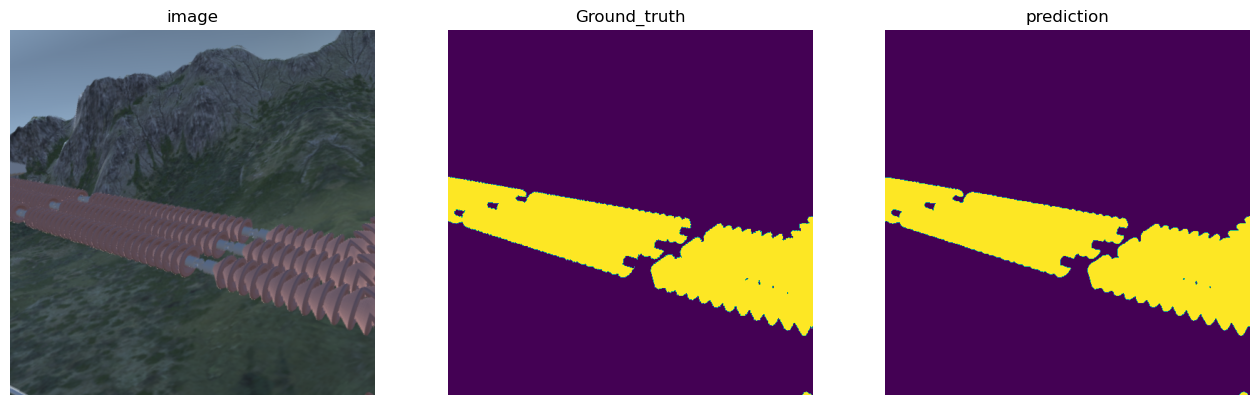

In [23]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [24]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/linknet_vgg19_polymer.pth')

In [25]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/linknet_vgg19_polymer.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_20428\2915063632.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [26]:
model.to('cuda')

Linknet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [27]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [28]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [29]:
real_data = SegmentDataset(dir,2,transform=transform )

In [30]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [31]:
#images, masks = next(iter(real_dataloader))

In [32]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [33]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [34]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [35]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()